In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

%matplotlib inline

plt.style.use('default') 
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid")

pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')


In [2]:
url_train_labels = 'https://raw.githubusercontent.com/Tyavicoli/pandas/main/train_labels.csv'
url_train_values ='https://raw.githubusercontent.com/Tyavicoli/pandas/main/train_values.csv'
df = pd.read_csv(url_train_labels,nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
edificios = pd.read_csv(url_train_values,dtype=datatypes)
daños = pd.read_csv(url_train_labels,dtype={'building_id':np.int32,'damage_grade':'category'})


**Analisis de sectores**

<AxesSubplot:title={'center':'Top 10 sectores mas afectados (del 1 al 5)'}>

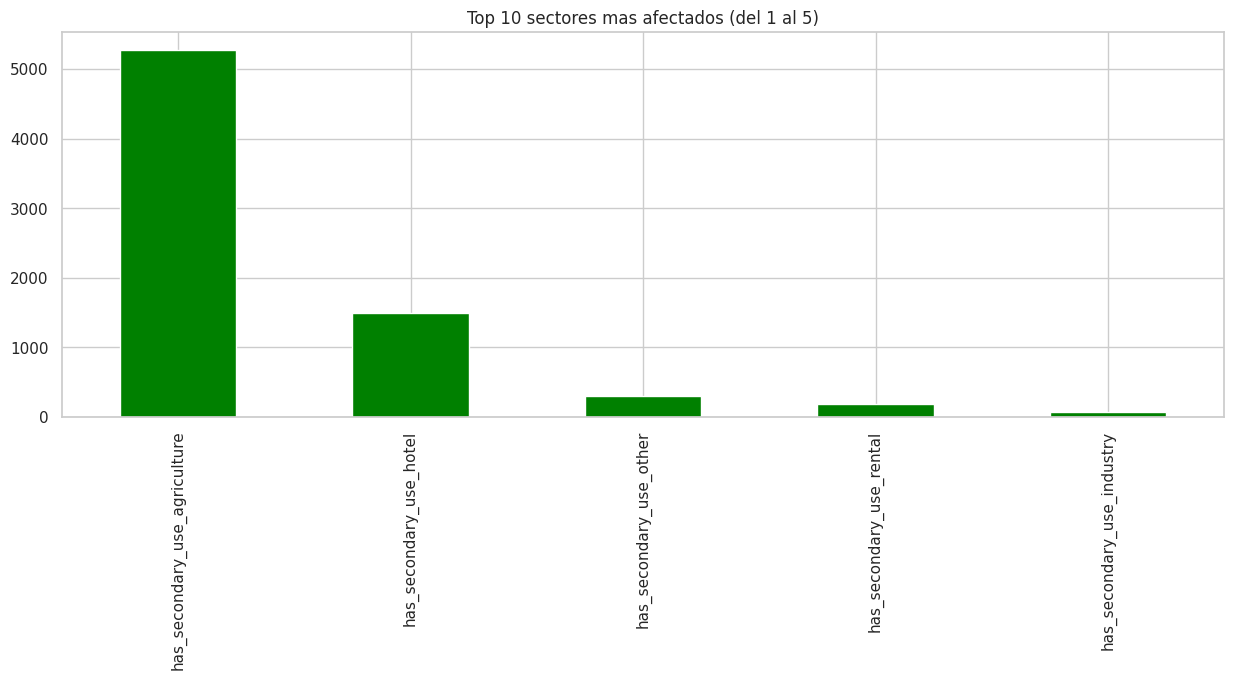

In [3]:
df_entero = edificios.merge(daños, left_on = 'building_id', right_on = 'building_id')
edificios_daño_3 = df_entero.loc[df_entero['damage_grade'] == '3', :]
edificios_daño_3_por_sector = edificios_daño_3.groupby('damage_grade').sum().reset_index()
edificios_daño_3_por_sector.iloc[2,22:].sort_values(ascending = False).iloc[:5].plot(kind='bar',color='green',figsize=(15,5), title='Top 10 sectores mas afectados (del 1 al 5)')

<AxesSubplot:title={'center':'Top 10 sectores mas afectados (del 6 al 10)'}>

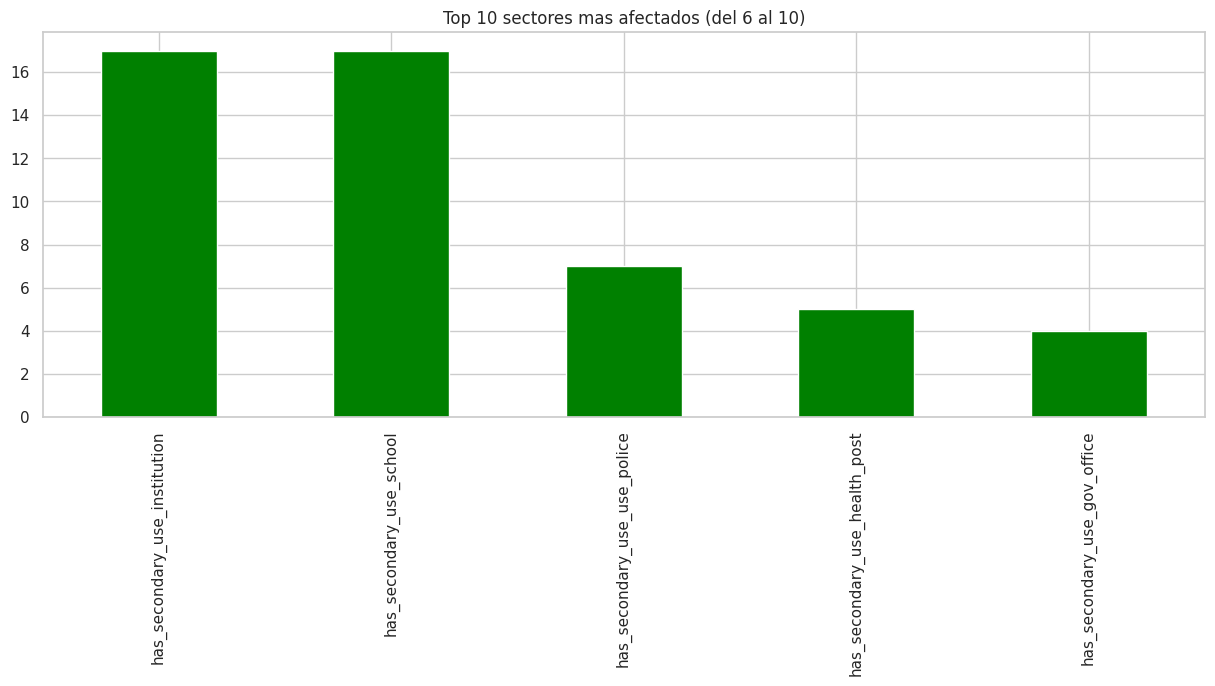

In [4]:
edificios_daño_3_por_sector.iloc[2,22:].sort_values(ascending = False).iloc[5:].plot(kind='bar',color='green',figsize=(15,5), title='Top 10 sectores mas afectados (del 6 al 10)')

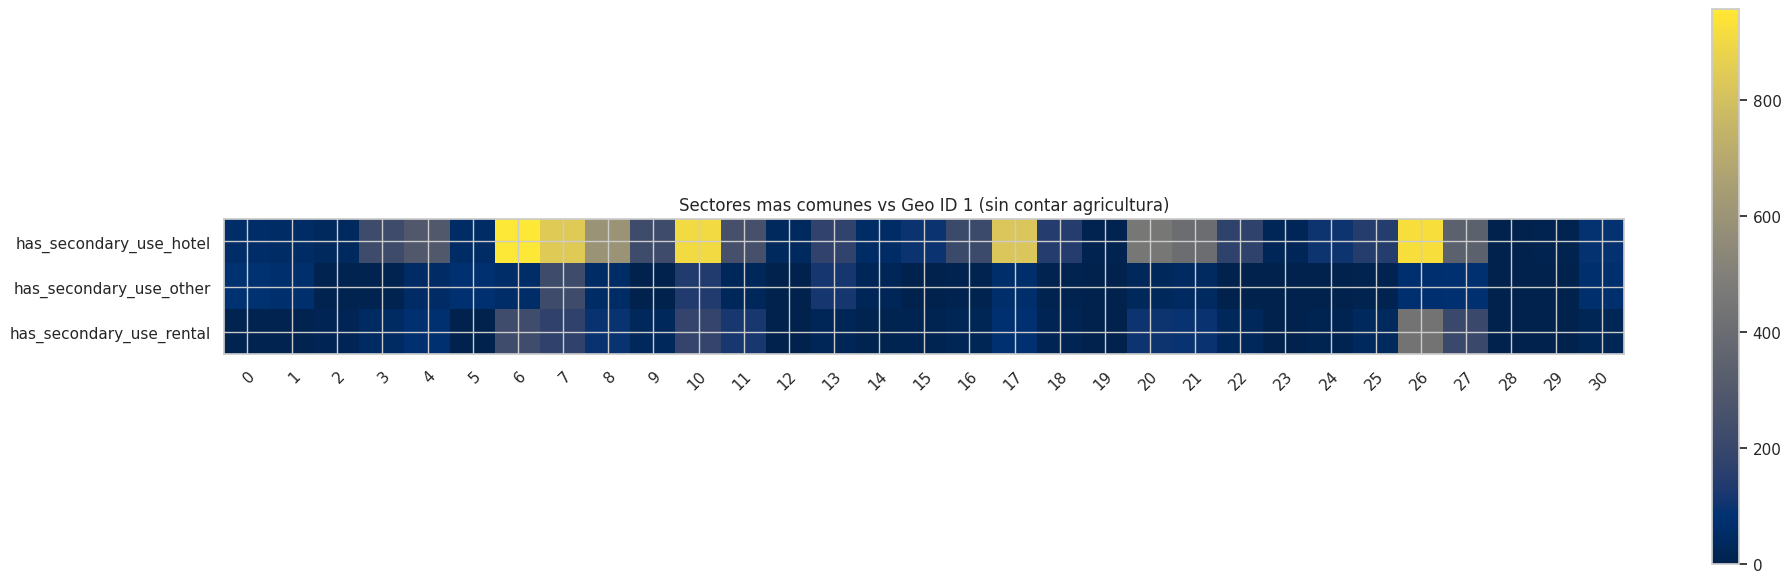

In [5]:
table2 = df_entero.loc[:,['geo_level_1_id', 'has_secondary_use_hotel', 'has_secondary_use_other', 'has_secondary_use_rental']].groupby('geo_level_1_id').sum().T

fig2, ax2 = plt.subplots(figsize=(20, 6))
im = ax2.imshow(table2,cmap= 'cividis')
cbar = ax2.figure.colorbar(im, ax=ax2)
ax2.set_xticks(np.arange(len(table2.columns)))
ax2.set_yticks(np.arange(len(table2.index)))

ax2.set_xticklabels(table2.columns)
ax2.set_yticklabels(table2.index)


# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax2.set_title("Sectores mas comunes vs Geo ID 1 (sin contar agricultura)")
fig2.tight_layout()
plt.show()

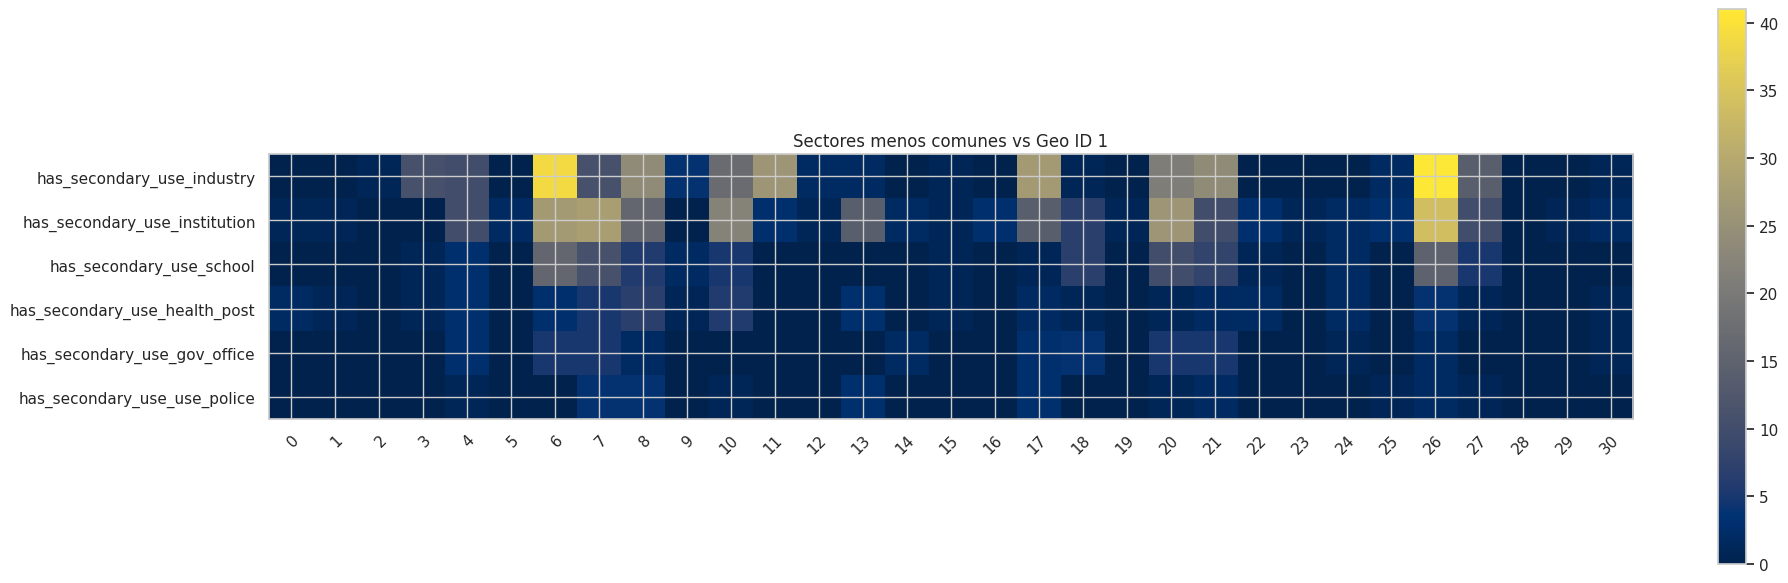

In [6]:
table2 = df_entero.loc[:,['geo_level_1_id', 'has_secondary_use_industry','has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police']].groupby('geo_level_1_id').sum().T

fig2, ax2 = plt.subplots(figsize=(20, 6))
im = ax2.imshow(table2,cmap= 'cividis')
cbar = ax2.figure.colorbar(im, ax=ax2)
ax2.set_xticks(np.arange(len(table2.columns)))
ax2.set_yticks(np.arange(len(table2.index)))

ax2.set_xticklabels(table2.columns)
ax2.set_yticklabels(table2.index)


# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax2.set_title("Sectores menos comunes vs Geo ID 1")
fig2.tight_layout()
plt.show()

**Analisis de familias mas afectadas**

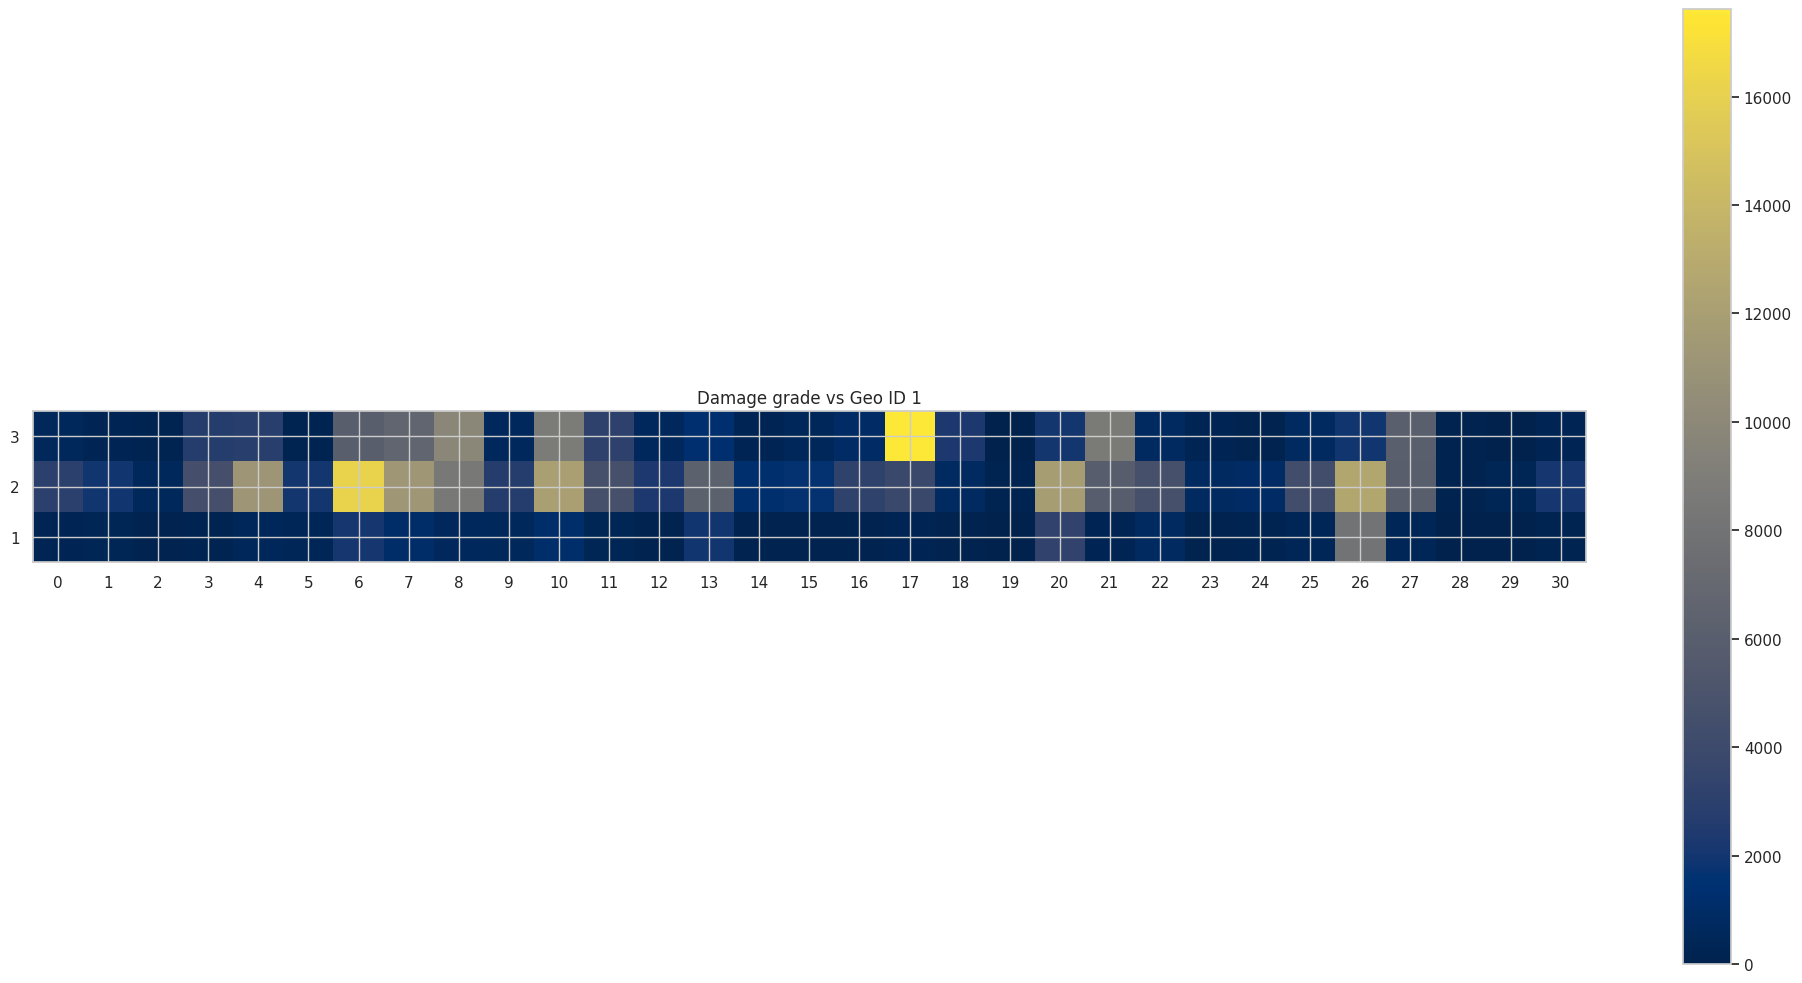

In [7]:
geoidvsdamage = df_entero.groupby(['damage_grade','geo_level_1_id'])['geo_level_1_id'].agg(['count']).reset_index()

table = pd.pivot_table(geoidvsdamage, values='count', index=['damage_grade'],columns=['geo_level_1_id'], aggfunc=np.sum,fill_value=0)
fig, ax = plt.subplots(figsize=(20,10))
im = ax.imshow(table,cmap= 'cividis')
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xticks(np.arange(len(table.columns)))
ax.set_yticks(np.arange(len(table.index)))

ax.set_xticklabels(table.columns)
ax.set_yticklabels(table.index)
ax.invert_yaxis()
ax.set_title("Damage grade vs Geo ID 1")
fig.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Cantidad de familias mas afectadas por Geo ID 1'}>

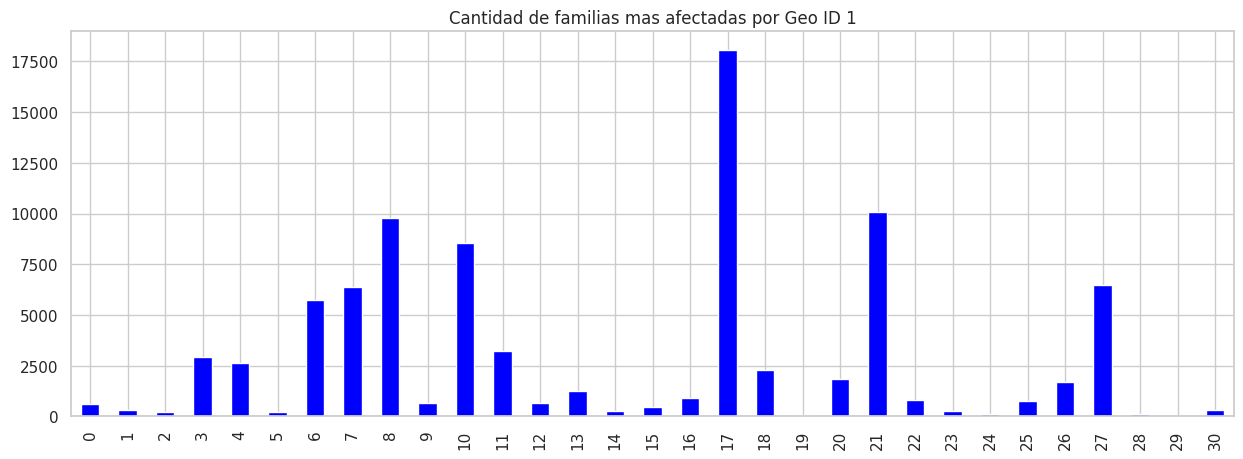

In [8]:
edificios_zona_geo_1 = edificios_daño_3.groupby('geo_level_1_id').sum().reset_index()
edificios_zona_geo_1['count_families'].plot(kind='bar',color='blue',figsize=(15,5), title='Cantidad de familias mas afectadas por Geo ID 1')

**Analisis de materiales vs daño**

In [9]:
edificios_por_daño_cimiento = df_entero.groupby(['foundation_type','damage_grade']).count().reset_index()
edificios_por_daño_cimiento = edificios_por_daño_cimiento.iloc[:,:3]
pivoted = pd.pivot(edificios_por_daño_cimiento,index='damage_grade',columns='foundation_type').rename(columns={'building_id':'cimiento'})
level_0 = pivoted.columns.get_level_values(0)
level_1 = pivoted.columns.get_level_values(1)
pivoted.columns = level_0 + '_' + level_1
pivoted = pivoted.reset_index().iloc[:,1:]
damage_cim_perc = pivoted.transpose()
damage_cim_perc = damage_cim_perc.div(damage_cim_perc.sum(axis=1), axis=0)
damage_cim_perc = damage_cim_perc.transpose()

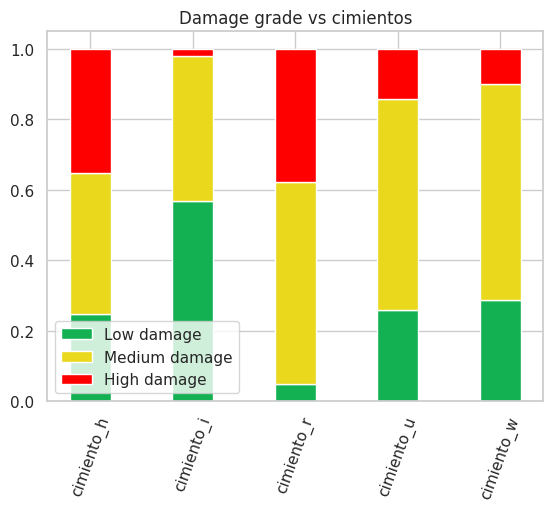

In [10]:
labels = damage_cim_perc.columns.to_list()

low_affected,medium_affected,high_affected = np.array(damage_cim_perc.values.tolist())

width = 0.4
fig, ax = plt.subplots()

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Damage grade vs cimientos')
ax.legend()
plt.xticks(rotation=70)
plt.show()

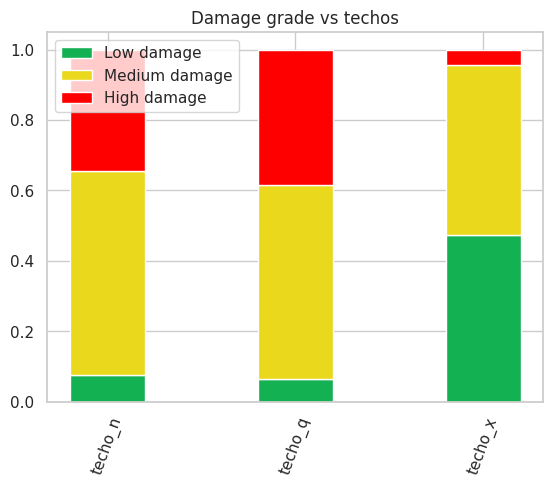

In [11]:
edificios_por_daño_techo = df_entero.groupby(['roof_type','damage_grade']).count().reset_index()
edificios_por_daño_techo = edificios_por_daño_techo.iloc[:,:3]
pivoted = pd.pivot(edificios_por_daño_techo,index='damage_grade',columns='roof_type').rename(columns={'building_id':'techo'})
level_0 = pivoted.columns.get_level_values(0)
level_1 = pivoted.columns.get_level_values(1)
pivoted.columns = level_0 + '_' + level_1
pivoted = pivoted.reset_index().iloc[:,1:]
damage_techo_perc = pivoted.transpose()
damage_techo_perc = damage_techo_perc.div(damage_techo_perc.sum(axis=1), axis=0)
damage_techo_perc = damage_techo_perc.transpose()
labels = damage_techo_perc.columns.to_list()

low_affected,medium_affected,high_affected = np.array(damage_techo_perc.values.tolist())

width = 0.4
fig, ax = plt.subplots()

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Damage grade vs techos')
ax.legend()
plt.xticks(rotation=70)
plt.show()

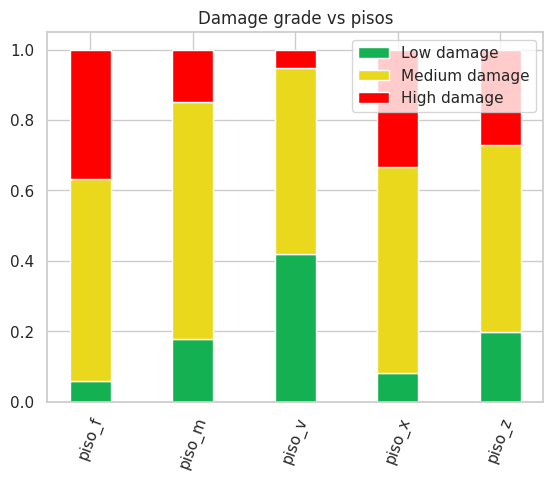

In [12]:
edificios_por_daño_piso = df_entero.groupby(['ground_floor_type','damage_grade']).count().reset_index()
edificios_por_daño_piso = edificios_por_daño_piso.iloc[:,:3]
pivoted = pd.pivot(edificios_por_daño_piso,index='damage_grade',columns='ground_floor_type').rename(columns={'building_id':'piso'})
level_0 = pivoted.columns.get_level_values(0)
level_1 = pivoted.columns.get_level_values(1)
pivoted.columns = level_0 + '_' + level_1
pivoted = pivoted.reset_index().iloc[:,1:]
damage_piso_perc = pivoted.transpose()
damage_piso_perc = damage_piso_perc.div(damage_piso_perc.sum(axis=1), axis=0)
damage_piso_perc = damage_piso_perc.transpose()
labels = damage_piso_perc.columns.to_list()

low_affected,medium_affected,high_affected = np.array(damage_piso_perc.values.tolist())

width = 0.4
fig, ax = plt.subplots()

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Damage grade vs pisos')
ax.legend()
plt.xticks(rotation=70)
plt.show()

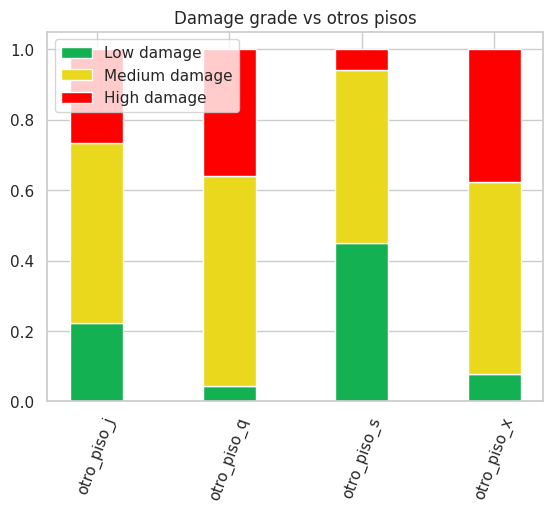

In [13]:
edificios_por_daño_otros_pisos = df_entero.groupby(['other_floor_type','damage_grade']).count().reset_index()
edificios_por_daño_otros_pisos = edificios_por_daño_otros_pisos.iloc[:,:3]
pivoted = pd.pivot(edificios_por_daño_otros_pisos,index='damage_grade',columns='other_floor_type').rename(columns={'building_id':'otro_piso'})
level_0 = pivoted.columns.get_level_values(0)
level_1 = pivoted.columns.get_level_values(1)
pivoted.columns = level_0 + '_' + level_1
pivoted = pivoted.reset_index().iloc[:,1:]
damage_otro_piso_perc = pivoted.transpose()
damage_otro_piso_perc = damage_otro_piso_perc.div(damage_otro_piso_perc.sum(axis=1), axis=0)
damage_otro_piso_perc = damage_otro_piso_perc.transpose()
labels = damage_otro_piso_perc.columns.to_list()

low_affected,medium_affected,high_affected = np.array(damage_otro_piso_perc.values.tolist())

width = 0.4
fig, ax = plt.subplots()

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Damage grade vs otros pisos')
ax.legend()
plt.xticks(rotation=70)
plt.show()

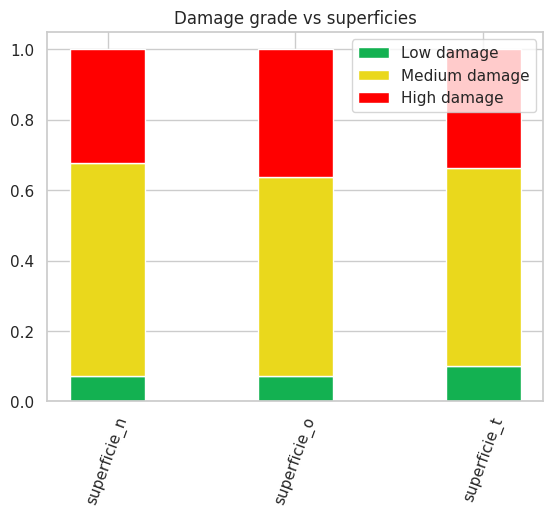

In [14]:
edificios_por_daño_superficie_terreste = df_entero.groupby(['land_surface_condition','damage_grade']).count().reset_index()
edificios_por_daño_superficie_terreste = edificios_por_daño_superficie_terreste.iloc[:,:3]
pivoted = pd.pivot(edificios_por_daño_superficie_terreste,index='damage_grade',columns='land_surface_condition').rename(columns={'building_id':'superficie'})
level_0 = pivoted.columns.get_level_values(0)
level_1 = pivoted.columns.get_level_values(1)
pivoted.columns = level_0 + '_' + level_1
pivoted = pivoted.reset_index().iloc[:,1:]
damage_superficie_terreste_perc = pivoted.transpose()
damage_superficie_terreste_perc = damage_superficie_terreste_perc.div(damage_superficie_terreste_perc.sum(axis=1), axis=0)
damage_superficie_terreste_perc = damage_superficie_terreste_perc.transpose()
labels = damage_superficie_terreste_perc.columns.to_list()

low_affected,medium_affected,high_affected = np.array(damage_superficie_terreste_perc.values.tolist())

width = 0.4
fig, ax = plt.subplots()

ax.bar(labels, low_affected, width, label='Low damage',color='#13b151')
ax.bar(labels, medium_affected, width, bottom=low_affected,label='Medium damage', color='#ead81c')
ax.bar(labels, high_affected, width, bottom=low_affected+medium_affected,label='High damage', color='red')

ax.set_title('Damage grade vs superficies')
ax.legend()
plt.xticks(rotation=70)
plt.show()